In [1]:
from kan import *
import pytz
import time
import datetime
from data_process import data_process_without_norm
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import copy
import pandas as pd

df = data_process_without_norm()
df = df.drop("entsoe",axis=1)
loc_tz = pytz.timezone('Europe/Zurich')
split_date_train_ = loc_tz.localize(datetime.datetime(2016,1,1,0,0,0,0))
split_date_train = loc_tz.localize(datetime.datetime(2016,3,1,0,0,0,0))
split_date_test = loc_tz.localize(datetime.datetime(2016,3,15,0,0,0,0))

df_train_ = df.loc[(split_date_train_ < df.index)]
df_train = df_train_.loc[df_train_.index <= split_date_train].copy()
_temp_df = df.loc[split_date_test > df.index]
df_test = _temp_df.loc[_temp_df.index > split_date_train].copy()

# Input standardization
scaler_input = StandardScaler()
# scaler_input = MinMaxScalerr()
_temp_scaled_input_data = scaler_input.fit_transform(df_train.iloc[:,1:])
x_train_input = _temp_scaled_input_data

#Output standardization
scaler_output = StandardScaler()
# scaler_input = MinMaxScaler()
_temp_scaled_output_data = scaler_output.fit_transform(np.array(df_train.iloc[:,0]).reshape(-1,1))
x_train_label = _temp_scaled_output_data

#Test set standardization
x_test_input = scaler_input.transform(df_test.iloc[:,1:])
x_test_label = scaler_output.transform(np.array(df_test.iloc[:,0]).reshape(-1,1))

_temp_test_input = np.hstack((x_test_input[:,:8],x_test_input[:,-3:-1]))
_temp_test_label = x_test_label
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

_temp_train_input = np.hstack((x_train_input[:, :8], x_train_input[:, -3:-1]))
_temp_train_label = x_train_label

# 将数据转换为 PyTorch 张量
train_input_tensor = torch.tensor(_temp_train_input.astype(np.float32))
train_label_tensor = torch.tensor(_temp_train_label.astype(np.float32))

test_input_tensor = torch.tensor(_temp_test_input.astype(np.float32))
test_label_tensor = torch.tensor(_temp_test_label.astype(np.float32))


In [2]:
# Find the best configuration
results_df = pd.read_csv('./parameters_configuration/KAN_BaseConfig_SPRING.csv',index_col=0).to_numpy()
best_config = results_df[results_df[:,-1].argmin(),:]

Best_step = best_config[0].astype(int)
Best_lr = best_config[1]
Best_grid = best_config[2].astype(int)
Best_k = best_config[3].astype(int)
Best_internal_units = best_config[4].astype(int)
Best_batch = best_config[5].astype(int)
Best_lamb = best_config[6].astype(float)
Best_lamb_entropy = best_config[7].astype(float)

print("\nBest Configuration: Step: {}, Learning Rate: {}, Grid: {}, K: {}, Internal Units: {}, Batch Size: {}, Lamb: {}, Lamb Entropy: {}".format(Best_step, Best_lr, Best_grid, Best_k, Best_internal_units, Best_batch, Best_lamb, Best_lamb_entropy))


Best Configuration: Step: 100, Learning Rate: 0.01, Grid: 12, K: 3, Internal Units: 16, Batch Size: 64, Lamb: 0.01, Lamb Entropy: 10.0


In [3]:
model = KAN(width=[10, int(Best_internal_units), 1], grid=Best_grid, k=Best_k, auto_save=False, seed=0, device=device)
dataset = dict()
dataset['train_input'] = torch.tensor(_temp_train_input.astype(np.float32))
dataset['train_label'] = torch.tensor(_temp_train_label.astype(np.float32))

dataset['test_input'] = torch.tensor(_temp_test_input.astype(np.float32))
dataset['test_label'] = torch.tensor(_temp_test_label.astype(np.float32))

for i in range(Best_internal_units):
    model.fix_symbolic(0, 9, i, 'sin', fit_params_bool=False)
    model.fix_symbolic(0, 8, i, 'sin', fit_params_bool=False)
        
model.auto_save = True
# model.fit(dataset, opt="LBFGS", steps=Best_step, batch=Best_batch, lr=Best_lr, lamb=Best_lamb, lamb_entropy=Best_lamb_entropy);
model.fit(dataset, opt="Adam", steps=Best_step, batch=Best_batch, lr=Best_lr, lamb=Best_lamb, lamb_entropy=Best_lamb_entropy);

saving model version 0.1


In [4]:

# Find the best configuration
results_df = pd.read_csv('./parameters_configuration/NN+KAN-SPIRNG.csv',index_col=0).to_numpy()
best_config = results_df[results_df[:,-1].argmin(),:]
Best_threshold_1 = best_config[0]
Best_threshold_2 = best_config[1]
print("\nBest Configuration: Best_threshold_1: {}, Best_threshold_2: {}".format(Best_threshold_1, Best_threshold_2))


Best Configuration: Best_threshold_1: 0.02, Best_threshold_2: 0.03


saving model version 0.1


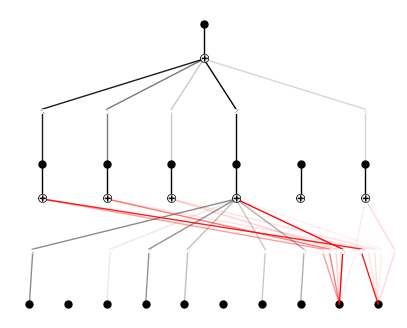

In [5]:
model = model.prune(node_th=Best_threshold_1, edge_th=Best_threshold_2);
model.auto_save = True
model.fit(dataset, opt="Adam", steps=Best_step, batch=Best_batch, lr=Best_lr, lamb=Best_lamb, lamb_entropy=Best_lamb_entropy);
model.plot()

In [6]:
# source conde prune_input return input_mask
model,input_mask = model.prune_input()
# model.edge_scores
# model.node_scores

keep: [True, False, True, True, True, False, True, True, True, True]
saving model version 0.2


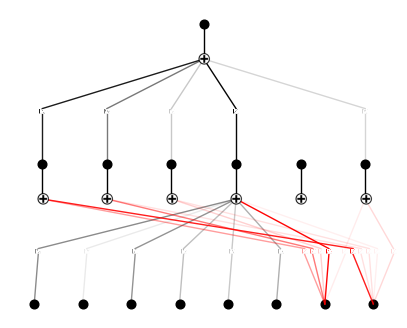

In [7]:
model.plot()

In [8]:
lib = ['x','x^2','exp','sqrt','tanh','sin','arctanh']
model.auto_symbolic(lib=lib)
# model.symbolic_formula()

fixing (0,0,0) with 0
fixing (0,0,1) with 0
fixing (0,0,2) with 0
fixing (0,0,3) with x, r2=0.6218512654304504, c=1
fixing (0,0,4) with 0
fixing (0,0,5) with 0
fixing (0,1,0) with 0
fixing (0,1,1) with 0
fixing (0,1,2) with 0
fixing (0,1,3) with x, r2=0.22308853268623352, c=1
fixing (0,1,4) with 0
fixing (0,1,5) with 0
fixing (0,2,0) with 0
fixing (0,2,1) with 0
fixing (0,2,2) with 0
fixing (0,2,3) with x, r2=0.8910674452781677, c=1
fixing (0,2,4) with 0
fixing (0,2,5) with 0
fixing (0,3,0) with 0
fixing (0,3,1) with 0
fixing (0,3,2) with 0
fixing (0,3,3) with x, r2=0.5167895555496216, c=1
fixing (0,3,4) with 0
fixing (0,3,5) with 0
fixing (0,4,0) with 0
fixing (0,4,1) with 0
fixing (0,4,2) with 0
fixing (0,4,3) with x, r2=0.27104657888412476, c=1
fixing (0,4,4) with 0
fixing (0,4,5) with 0
fixing (0,5,0) with 0
fixing (0,5,1) with 0
fixing (0,5,2) with 0
fixing (0,5,3) with x, r2=0.40133213996887207, c=1
fixing (0,5,4) with 0
fixing (0,5,5) with 0
skipping (0,6,0) since already symbol

In [9]:
# def revise_dataset(dataset,input_index):
#     dataset['train_input'] = dataset['train_input'][:,input_index]
#     dataset['test_input'] = dataset['test_input'][:,input_index]
#     return dataset
# true_indices = np.where(input_mask.detach().numpy())[0]
# dataset = revise_dataset(dataset,true_indices)
model.fit(dataset, opt="Adam", steps=Best_step, batch=Best_batch, lr=Best_lr);

saving model version 0.4


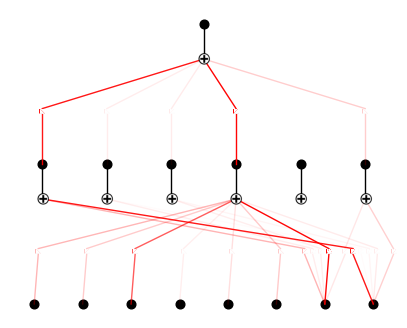

In [10]:
model.plot()

In [11]:
model.symbolic_formula()

([-0.157692997029526*x_1 + 0.113850113940205*x_2 + 0.245398832251325*x_3 - 0.0375700709960873*x_4 - 0.0743275047585727*x_5 - 0.116481679000977*x_6 - 0.204698512949699*sin(0.447511345148087*x_7 + 0.0286507196724415) - 0.0591604042364544*sin(0.499916136264801*x_7 - 0.1096510887146) + 0.0265937246139742*sin(0.98316103219986*x_7 - 0.023726150393486) + 0.937441504029815*sin(1.53568255901337*x_7 + 0.966745615005493) - 0.0301989758231221*sin(1.76254463195801*x_7 + 0.0300564803183079) + 0.130277511623152*sin(0.231478303670883*x_8 + 0.642546415328979) - 0.0100944301607952*sin(0.554427683353424*x_8 - 0.148667931556702) - 0.0930141061618751*sin(0.937524080276489*x_8 - 0.636243104934692) - 0.683908913102481*sin(1.11288797855377*x_8 - 0.608056306838989) + 0.0159048023483007*sin(1.70630741119385*x_8 + 0.206274792551994) - 0.452060809916076],
 [x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8])

In [12]:
def RMSE(_pre,_actual):
    MSE = ((_pre-_actual)**2)/15/24   
    return np.sqrt(MSE.sum())
    
def MAE(_pre,_actual):
    return (np.abs((_pre-_actual))).sum()/15/24
    
def MAPE(_pre,_actual):
    return ((np.abs((_pre-_actual)))/_actual).sum()/15/24
    
def evaluation(_pre,_actual): 
    return [RMSE(_pre,_actual),MAE(_pre,_actual),MAPE(_pre,_actual)]

In [13]:
pre_KAN = model.forward(dataset['test_input']).detach().numpy()

actual = scaler_output.inverse_transform(dataset['test_label'].reshape(-1,1))

pre_KAN_ = scaler_output.inverse_transform(pre_KAN)

result = dict()
result["KAN"] = evaluation(pre_KAN_,actual)

In [14]:
result

{'KAN': [442.20922703862385, 351.72743708702245, 0.04574528704168695]}

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import KFold
import pandas as pd
import time

# CNN 模型
class CNN(nn.Module):
    def __init__(self, num_inputs, num_outputs, conv_out_channels=16, time_step=24):
        super(CNN, self).__init__()
        self.conv = nn.Conv1d(in_channels=num_inputs, out_channels=conv_out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(conv_out_channels * time_step, num_outputs)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # 调整输入形状为 (batch_size, num_inputs, time_step)
        x = self.conv(x)
        x = self.relu(x)
        x = x.view(x.size(0), -1)  # 展平
        x = self.fc(x)
        return x

# LSTM 模型
class LSTM(nn.Module):
    def __init__(self, num_inputs, num_outputs, lstm_hidden_units=16):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=num_inputs, hidden_size=lstm_hidden_units, batch_first=True)
        self.fc = nn.Linear(lstm_hidden_units, num_outputs)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # 取最后一个时间步的输出
        x = self.fc(x)
        return x

# CNNLSTM 模型
class CNNLSTM(nn.Module):
    def __init__(self, num_inputs, num_outputs, conv_out_channels=16, lstm_hidden_units=16, time_step=24):
        super(CNNLSTM, self).__init__()
        self.conv = nn.Conv1d(in_channels=num_inputs, out_channels=conv_out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(input_size=conv_out_channels, hidden_size=lstm_hidden_units, batch_first=True)
        self.fc = nn.Linear(lstm_hidden_units, num_outputs)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # 调整输入形状为 (batch_size, num_inputs, time_step)
        x = self.conv(x)
        x = self.relu(x)
        x = x.permute(0, 2, 1)  # 调整回 LSTM 所需的输入形状 (batch_size, time_step, conv_out_channels)
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # 取最后一个时间步的输出
        x = self.fc(x)
        return x

# Transformer 模型
class Transformer(nn.Module):
    def __init__(self, num_inputs, num_outputs, d_model=16, num_heads=2, num_layers=2):
        super(Transformer, self).__init__()
        self.embedding = nn.Linear(num_inputs, d_model)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads),
            num_layers=num_layers
        )
        self.fc = nn.Linear(d_model, num_outputs)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer(x)
        x = self.fc(x)
        return x

# FCN1 模型
class FCN1(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_units=16):
        super(FCN1, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(num_inputs, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, num_outputs)
        )

    def forward(self, x):
        return self.net(x)

# FCN2 模型
class FCN2(nn.Module):
    def __init__(self, num_inputs, num_outputs, hidden_units1=32, hidden_units2=16):
        super(FCN2, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(num_inputs, hidden_units1),
            nn.ReLU(),
            nn.Linear(hidden_units1, hidden_units2),
            nn.ReLU(),
            nn.Linear(hidden_units2, num_outputs)
        )

    def forward(self, x):
        return self.net(x)

# KAN_ADD_NN 类
class KAN_ADD_NN(nn.Module):
    def __init__(self, module1, module2):
        super(KAN_ADD_NN, self).__init__()
        self.module1 = module1  # Neural network for f(x, theta1)
        self.module2 = module2  # Neural network for g(x, theta2)
        self.fc1 = nn.Linear(2, 1, bias=True)  # Linear layer to combine outputs of module1 and module2

    def forward(self, x1, x2):
        y1 = self.module1(x1)
        y2 = self.module2(x2)
        y = self.fc1(torch.cat((y1, y2), 1))
        return y

    def loss_func(self, x1, x2, y_actual):
        y_pre = self.forward(x1, x2)
        loss = torch.mean((y_pre - y_actual) ** 2)
        return loss

    def admm_step(self, x1, x2, y_actual, optimizer):
        optimizer.zero_grad()
        loss = self.loss_func(x1, x2, y_actual)+torch.abs(self.fc1.weight[:, 1])
        loss.backward()
        optimizer.step()

def create_time_series_data(data, time_step):
    num_samples = data.shape[0]
    time_series_data = []
    for i in range(num_samples - time_step + 1):
        time_series_data.append(data[i:i + time_step].clone().detach().numpy())
    return torch.tensor(np.array(time_series_data))


In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
results_df_cnn = pd.read_csv('./parameters_configuration/cnn_kan_ablation-SPRING.csv',index_col=0)
results_df_lstm = pd.read_csv('./parameters_configuration/cnn_lstm_kan_ablation-SPRING.csv',index_col=0)
results_df_cnn_lstm = pd.read_csv('./parameters_configuration/cnn_lstm_kan_ablation-SPRING.csv',index_col=0)
results_df_transformer = pd.read_csv('./parameters_configuration/transformer_kan_ablation-SPRING.csv',index_col=0)
results_df_fcn1 = pd.read_csv('./parameters_configuration/fcn1_kan_ablation-SPRING.csv',index_col=0)
results_df_fcn2 = pd.read_csv('./parameters_configuration/fcn2_kan_ablation-SPRING.csv',index_col=0)

In [20]:
# 训练和评估模型的函数
def train_and_test_model(model_class, learning_rate, batch_size, num_epochs, hidden_units, train_input_tensor, train_label_tensor, test_input_tensor, test_label_tensor, scaler_output, KAN_model, num_inputs=10, num_outputs=1, time_step=24):
    lr = learning_rate
    batch_size = batch_size
    num_epochs = num_epochs
    hidden_units = hidden_units
    
    if model_class in [CNN, CNNLSTM]:
        _model = model_class(num_inputs, num_outputs, hidden_units, time_step)
    else:
        _model = model_class(num_inputs, num_outputs, hidden_units)

    # 分割数据
    train_input_fold = train_input_tensor
    train_label_fold = train_label_tensor
    val_input_fold = train_input_tensor
    val_label_fold = train_label_tensor

    # 如果模型是CNN或LSTM，转换数据为时间序列格式
    if issubclass(model_class, (CNN, LSTM, CNNLSTM)):
        train_input_fold_series = create_time_series_data(train_input_fold, time_step)
        train_label_fold_series = train_label_fold[time_step - 1:]  # 对齐标签
        val_input_fold_series = create_time_series_data(val_input_fold, time_step)
        val_label_fold_series = val_label_fold[time_step - 1:]  # 对齐标签
        
        train_input_fold = train_input_fold[time_step - 1:]
        train_label_fold = train_label_fold[time_step - 1:]
        val_input_fold = val_input_fold[time_step - 1:]
        val_label_fold = val_label_fold[time_step - 1:]

        # 创建数据加载器
        train_loader = torch.utils.data.DataLoader(
            dataset=torch.utils.data.TensorDataset(train_input_fold.clone().detach(), train_input_fold_series.clone().detach(), train_label_fold.clone().detach()),
            batch_size=batch_size,
            shuffle=True
        )
        val_loader = torch.utils.data.DataLoader(
            dataset=torch.utils.data.TensorDataset(val_input_fold.clone().detach(), val_input_fold_series.clone().detach(), val_label_fold.clone().detach()),
            batch_size=batch_size,
            shuffle=False
        )
    else:
        # 创建数据加载器
        train_loader = torch.utils.data.DataLoader(
            dataset=torch.utils.data.TensorDataset(train_input_fold.clone().detach(),train_input_fold.clone().detach(), train_label_fold.clone().detach()),
            batch_size=batch_size,
            shuffle=True
        )
        val_loader = torch.utils.data.DataLoader(
            dataset=torch.utils.data.TensorDataset(val_input_fold.clone().detach(),val_input_fold.clone().detach(), val_label_fold.clone().detach()),
            batch_size=batch_size,
            shuffle=False
        )

    # 确保第一个模型是 KAN_model
    model_ADD = KAN_ADD_NN(KAN_model, _model)
    optimizer = optim.Adam(model_ADD.parameters(), lr=lr)

    # 训练模型
    start_time = time.time()
    for epoch in range(num_epochs):
        model_ADD.train()
        for x, y, z in train_loader:
            model_ADD.admm_step(x, y, z, optimizer)  # 使用可能不相同的输入 x 和 y

        # if (epoch + 1) % 10 == 0:
        #     loss = model_ADD.loss_func(x, y, z)
        #     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
    
    # 如果模型是CNN或LSTM，转换数据为时间序列格式
    if issubclass(model_class, (CNN, LSTM, CNNLSTM)):
        test_input_series = create_time_series_data(test_input_tensor, time_step)
        test_label_series = test_label_tensor[time_step - 1:]  # 对齐标签
        
        test_input = test_input_tensor[time_step - 1:]
        test_label = test_label_tensor[time_step - 1:]
    else:
        test_input_series = test_input_tensor
        test_label_series = test_label_tensor
        
        test_input = test_input_tensor
        test_label = test_label_tensor

    
    # 验证模型
    model.eval()
    with torch.no_grad():
        output = model_ADD.fc1.weight[:,0]*model_ADD.module1(test_input) + model_ADD.fc1.bias
        output_inverse = scaler_output.inverse_transform(output.numpy())
        test_label_inverse = scaler_output.inverse_transform(test_label)

    return evaluation(output_inverse,test_label_inverse)

In [21]:
# 找到每个模型的最佳配置
def get_best_config(results_df):
    best_config = results_df.loc[results_df['avg_val_loss'].idxmin(), ['learning_rate', 'batch_size', 'num_epochs', 'hidden_units']]
    return {
        'learning_rate': best_config['learning_rate'],
        'batch_size': int(best_config['batch_size']),
        'num_epochs': int(best_config['num_epochs']),
        'hidden_units': int(best_config['hidden_units'])      
    }

# 获取每个模型的最佳配置
best_config_cnn = get_best_config(results_df_cnn)
best_config_lstm = get_best_config(results_df_lstm)
best_config_cnn_lstm = get_best_config(results_df_cnn_lstm)
best_config_transformer = get_best_config(results_df_transformer)
best_config_fcn1 = get_best_config(results_df_fcn1)
best_config_fcn2 = get_best_config(results_df_fcn2)

In [22]:
# 训练和测试每个模型，并打印结果
cnn_test_results = train_and_test_model(CNN, **best_config_cnn, train_input_tensor=train_input_tensor, train_label_tensor=train_label_tensor, test_input_tensor=test_input_tensor, test_label_tensor=test_label_tensor, scaler_output=scaler_output, KAN_model = model.copy())
print("CNN Test Results:", cnn_test_results)
result["cnn_KAN"] = cnn_test_results

lstm_test_results = train_and_test_model(LSTM, **best_config_lstm, train_input_tensor=train_input_tensor, train_label_tensor=train_label_tensor, test_input_tensor=test_input_tensor, test_label_tensor=test_label_tensor, scaler_output=scaler_output,KAN_model = model.copy())
print("LSTM Test Results:", lstm_test_results)
result["lstm_KAN"] = lstm_test_results

cnn_lstm_test_results = train_and_test_model(CNNLSTM, **best_config_cnn_lstm, train_input_tensor=train_input_tensor, train_label_tensor=train_label_tensor, test_input_tensor=test_input_tensor, test_label_tensor=test_label_tensor, scaler_output=scaler_output, KAN_model = model.copy())
print("CNN-LSTM Test Results:", cnn_lstm_test_results)
result["cnn_lstm_KAN"] = cnn_lstm_test_results

transformer_test_results = train_and_test_model(Transformer, **best_config_transformer, train_input_tensor=train_input_tensor, train_label_tensor=train_label_tensor, test_input_tensor=test_input_tensor, test_label_tensor=test_label_tensor, scaler_output=scaler_output, KAN_model = model.copy())
print("Transformer Test Results:", transformer_test_results)
result["transformer_KAN"] = transformer_test_results

fcn1_test_results = train_and_test_model(FCN1, **best_config_fcn1, train_input_tensor=train_input_tensor, train_label_tensor=train_label_tensor, test_input_tensor=test_input_tensor, test_label_tensor=test_label_tensor, scaler_output=scaler_output, KAN_model = model.copy())
print("FCN1 Test Results:", fcn1_test_results)
result["fcn1_KAN"] = fcn1_test_results

fcn2_test_results = train_and_test_model(FCN2, **best_config_fcn2, train_input_tensor=train_input_tensor, train_label_tensor=train_label_tensor, test_input_tensor=test_input_tensor, test_label_tensor=test_label_tensor, scaler_output=scaler_output, KAN_model = model.copy())
print("FCN2 Test Results:", fcn2_test_results)
result["fcn2_KAN"] = fcn2_test_results

CNN Test Results: [{'RMSE': 745.1079635906273, 'MAE': 625.365397307038, 'MAPE': 8.046180822033485}]
LSTM Test Results: [{'RMSE': 767.4539560552965, 'MAE': 629.4645873528536, 'MAPE': 7.9865101386461}]
CNN-LSTM Test Results: [{'RMSE': 724.2659189854322, 'MAE': 610.8866016180311, 'MAPE': 7.871400062306161}]


C:\Users\23124862r\AppData\Local\anaconda3\envs\kan\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Transformer Test Results: [{'RMSE': 678.746030710318, 'MAE': 596.7321932876373, 'MAPE': 7.8309498898950185}]
FCN1 Test Results: [{'RMSE': 739.6258547259933, 'MAE': 651.8383722363377, 'MAPE': 8.795644171978557}]
FCN2 Test Results: [{'RMSE': 800.3271684947728, 'MAE': 648.8441178558352, 'MAPE': 8.164523377560098}]


In [23]:
result

{'KAN': [442.20922703862385, 351.72743708702245, 0.04574528704168695],
 'cnn_KAN': [{'RMSE': 745.1079635906273,
   'MAE': 625.365397307038,
   'MAPE': 8.046180822033485}],
 'lstm_KAN': [{'RMSE': 767.4539560552965,
   'MAE': 629.4645873528536,
   'MAPE': 7.9865101386461}],
 'cnn_lstm_KAN': [{'RMSE': 724.2659189854322,
   'MAE': 610.8866016180311,
   'MAPE': 7.871400062306161}],
 'transformer_KAN': [{'RMSE': 678.746030710318,
   'MAE': 596.7321932876373,
   'MAPE': 7.8309498898950185}],
 'fcn1_KAN': [{'RMSE': 739.6258547259933,
   'MAE': 651.8383722363377,
   'MAPE': 8.795644171978557}],
 'fcn2_KAN': [{'RMSE': 800.3271684947728,
   'MAE': 648.8441178558352,
   'MAPE': 8.164523377560098}]}